In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn

import os
import csv
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Lambda, Flatten, Dense, Convolution2D
from keras.models import load_model
from keras import callbacks
from keras.optimizers import Adam
%matplotlib inline

Using TensorFlow backend.


In [3]:
# load data
dataLocation = './data/'
samples = pd.read_csv(dataLocation + 'driving_log.csv')
samples_nonzero = samples[samples.steering != 0]  # steering != 0
samples_zero = (samples[samples.steering == 0]).sample(frac=.1) # steering == 0

print('size of samples: ', len(samples))

size of samples:  8036


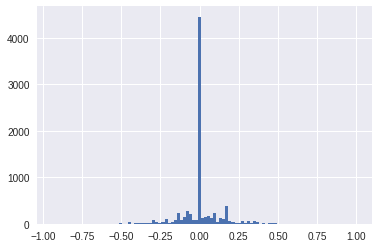

In [4]:
samples.steering.hist(bins=100)

In [5]:
from sklearn.utils import shuffle
samples = shuffle(samples)

training example m : 2269
['IMG/center_2016_12_01_13_36_28_129.jpg', ' IMG/left_2016_12_01_13_36_28_129.jpg', ' IMG/right_2016_12_01_13_36_28_129.jpg', ' 0', ' 0.9855326', ' 0', ' 30.18664']
(160, 320, 3)


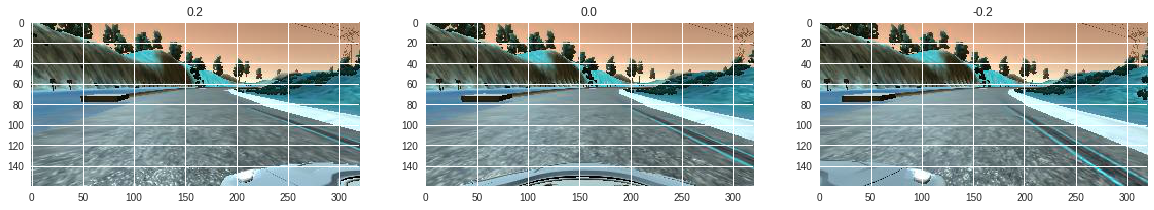

In [21]:
correction = 0.2 # this is a parameter to tune

#Loading CSV File
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# visualize one sample
m = np.random.randint(0,len(samples))
print('training example m :', m)

sample = samples[m]
print(sample)

center_img = cv2.imread('./data/IMG/'+sample[0].split('/')[-1])
left_img = cv2.imread('./data/IMG/'+sample[1].split('/')[-1])
right_img = cv2.imread('./data/IMG/'+sample[2].split('/')[-1])

center_angle = float(sample[3])
left_angle = center_angle + correction
right_angle = center_angle - correction

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(left_img)
plt.title(left_angle)
plt.subplot(132)
plt.imshow(center_img)
plt.title(center_angle)
plt.subplot(133)
plt.imshow(right_img)
plt.title(right_angle)

print(center_img.shape)

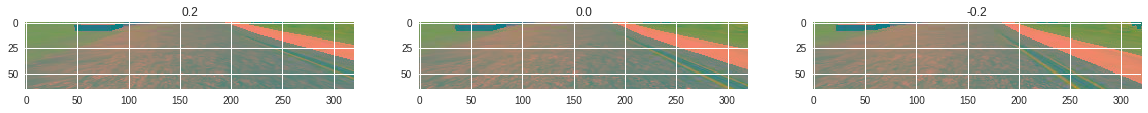

In [22]:
# Crop top and bottom images to remove sky and front of the car (NVIDIA's paper)
def preprocessing(image):
    # crop to 90x320x3
    image = image[70:135,:,:]
    
    # scale to 160x320x3 (same as NVIDIA)
    # image = cv2.resize(image,(320, 160), interpolation = cv2.INTER_AREA)

    # convert to YUV color space (same as NVIDIA)
    return cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
    # return image
    
center_img = preprocessing(center_img)
left_img = preprocessing(left_img)
right_img = preprocessing(right_img)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(left_img)
plt.title(left_angle)
plt.subplot(132)
plt.imshow(center_img)
plt.title(center_angle)
plt.subplot(133)
plt.imshow(right_img)
plt.title(right_angle)

In [23]:
def generator(samples, batch_size=16):
    num_samples = len(samples)
    correction = 0.2
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                for i in range(3):
                    name = './data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(name)
                    measurement = float(batch_sample[3])
                    if i == 1:
                        measurement = measurement + correction
                    elif i == 2:
                        measurement = measurement - correction
                    images.append(image)
                    measurements.append(measurement)

            #Data Augmentation
            #Flipping the images
            #Multiplying the steering angle measurement with -1
            augmented_images, augmented_measurements = [], []
            for image, measurement in zip(images, measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)

            #Converting the list into numpy arrays
            #This constitutes Features and Labels
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)

            yield sklearn.utils.shuffle(X_train, y_train)

In [28]:
#Loading CSV File
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

In [29]:
train_samples, validation_samples = train_test_split(samples[1:], test_size=0.2)

In [30]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=16)
validation_generator = generator(validation_samples, batch_size=16)

In [31]:
#Model Architecture starts from here
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

model = Sequential()

#Preprocessing the images
#Normalization and Mean Centre
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))

#Image cropping
model.add(Cropping2D(cropping=((70,25),(0,0))))

#Nvidia Model starts here
model.add(Convolution2D(24,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3,subsample=(2,2), activation="relu"))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch=len(train_samples)*3, 
                                     validation_data=validation_generator, 
                                     nb_val_samples=len(validation_samples)*3, 
                                     nb_epoch=2)

model.save('model.h5')

Epoch 1/2
19200/19284 [============================>.] - ETA: 1s - loss: 0.0215

/home/yiou/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


19296/19284 [==============================] - 499s - loss: 0.0216 - val_loss: 0.0175
Epoch 2/2
19368/19284 [==============================] - 485s - loss: 0.0167 - val_loss: 0.0166


dict_keys(['val_loss', 'loss'])


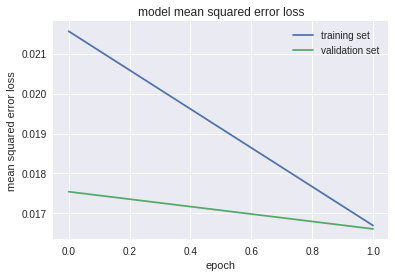

In [32]:
# print the keys contained in the history object
print(history_object.history.keys())

# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()